# Locus To Gene

This notebook aims to restructure and test L2G

In [1]:
import sys

import loguru
import matplotlib.pyplot as plt
import pandas as pd
import polars as pl

from gentropy.common.session import Session
from gentropy.dataset.dataset import Dataset


Loading BokehJS ...

In [2]:
RELEASE_PATH = "/home/mindos/data/ot-platform/2503-testrun-1/output"
session = Session(
    extended_spark_conf={"spark.driver.memory": "100g", "spark.driver.maxResultSize": 0}
)
logger = loguru.logger

25/02/27 09:25:48 WARN Utils: Your hostname, mindos resolves to a loopback address: 127.0.1.1; using 192.168.0.100 instead (on interface eno1)
25/02/27 09:25:48 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
25/02/27 09:25:48 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [3]:
%matplotlib

Using matplotlib backend: module://matplotlib_inline.backend_inline


## Methods

below you can find methods I used to analyse the datasets

In [4]:
def plot_distributions(df: pl.DataFrame, feature_cols: list[str]) -> None:
    """Plot the distribution of the features in the dataframe."""
    # Set the optimal number of dist plots
    combinations = [5, 4, 3, 2, 1]
    reminders = [len(feature_cols) % v for v in combinations]
    # for each combination count the reminder and save
    minimal_reminder = min(reminders)
    combination_idx = reminders.index(minimal_reminder)
    plots_per_row = combinations[combination_idx]

    logger.debug("Lowest reminder %s for %s ", minimal_reminder, plots_per_row)
    if len(feature_cols) % plots_per_row == 0:
        plots_per_col = len(feature_cols) // plots_per_row
    else:
        plots_per_col = len(feature_cols) // plots_per_row

    logger.debug(
        f"Shape [{plots_per_row}, {plots_per_col}]", plots_per_row, plots_per_col
    )
    with plt.style.context("fast"):
        fig, ax = plt.subplots(nrows=plots_per_col, ncols=plots_per_row)
        fig.tight_layout()
        fig.set_figheight(plots_per_col * 2)
        fig.set_figwidth(plots_per_row * 2)
        for i in range(0, plots_per_col):
            for j in range(0, plots_per_row):
                current_col_idx = i * plots_per_row + j
                if len(feature_cols) == current_col_idx:
                    break
                logger.debug(
                    f"Plotting to row {i}, col {j} data from {feature_cols[current_col_idx]}"
                )
                if ax.ndim == 1:
                    dims = i
                else:
                    dims = (i, j)
                ax[*dims].hist(x=df[feature_cols[current_col_idx]], bins=100)
                ax[*dims].set_title(feature_cols[current_col_idx], fontsize="small")

    return fig


In [5]:
def plot_wiskers(df: pl.DataFrame, feature_cols: list[str]):
    """Build the boxplots for the feature columns."""
    with plt.style.context("fast"):
        fig, axs = plt.subplots(nrows=1, ncols=1, figsize=(9, 4))
        all_data = df.select(feature_cols)
        axs.boxplot(
            all_data,
            orientation="horizontal",
            showmeans=True,
            tick_labels=all_data.columns,
        )
        axs.yaxis.grid(True)
        return fig


In [6]:
def calculate_skewness(df: pl.DataFrame, feature_cols: list[str]):
    """Calculate skewness for all columns."""
    return (
        df.select(*[pl.col(feature).skew() for feature in feature_cols])
        .transpose(
            include_header=True, header_name="feature_name", column_names=["value"]
        )
        .sort(pl.col("value"))
    )

## Feature matrix
Current implementation of the L2G feature matrix and how it is build

In [8]:
fm = session.load_data(path=f"{RELEASE_PATH}/l2g_feature_matrix")

### Feature matrix content

Below you can find what is exactly in the feature matrix

In [9]:
fm.show()
fm.printSchema()

25/02/27 09:27:40 WARN SparkStringUtils: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


+--------------------+---------------+---------------------+---------------------+----------------------------------+-------------------------+--------------------------------------+-------------------+--------------------------------+---------------+----------------------------+--------------------+---------------------------------+------------------+-------------------------------+--------------+---------------+--------------------+---------------------------------+------------------+-------------------------------+---------------------+--------------------+---------------------------------+------------------+-------------------------------+----------+-----------------------+------------+--------------------+
|        studyLocusId|         geneId|credibleSetConfidence|distanceFootprintMean|distanceFootprintMeanNeighbourhood|distanceSentinelFootprint|distanceSentinelFootprintNeighbourhood|distanceSentinelTss|distanceSentinelTssNeighbourhood|distanceTssMean|distanceTssMeanNeighbourhood

inside the feature matrix we have the static columns:
- studyLocusId
- geneId

and multiple feature columns, some of them are `double` type:
- geneCount500kb
- proteinGeneCount500kb
Other columns are `float` type.


### Check if the feature matrix feature fields distribution(s)

I want to see the distribution of the features in the feature matrix

In [9]:
static_columns = ["geneId", "studyLocusId"]
features = [f for f in fm.columns if f not in static_columns]
logger.info(f"We have {len(features)} features")


2025-02-26 07:18:42.227 | INFO     | __main__:<module>:3 - We have 28 features


2025-02-26 07:19:11.142 | DEBUG    | __main__:plot_distributions:11 - Lowest reminder %s for %s 
2025-02-26 07:19:11.142 | DEBUG    | __main__:plot_distributions:17 - Shape [4, 7]
2025-02-26 07:19:11.345 | DEBUG    | __main__:plot_distributions:28 - Plotting to row 0, col 0 data from credibleSetConfidence
2025-02-26 07:19:11.591 | DEBUG    | __main__:plot_distributions:28 - Plotting to row 0, col 1 data from distanceFootprintMean
2025-02-26 07:19:11.776 | DEBUG    | __main__:plot_distributions:28 - Plotting to row 0, col 2 data from distanceFootprintMeanNeighbourhood
2025-02-26 07:19:12.025 | DEBUG    | __main__:plot_distributions:28 - Plotting to row 0, col 3 data from distanceSentinelFootprint
2025-02-26 07:19:12.374 | DEBUG    | __main__:plot_distributions:28 - Plotting to row 1, col 0 data from distanceSentinelFootprintNeighbourhood
2025-02-26 07:19:12.630 | DEBUG    | __main__:plot_distributions:28 - Plotting to row 1, col 1 data from distanceSentinelTss
2025-02-26 07:19:12.822 | 

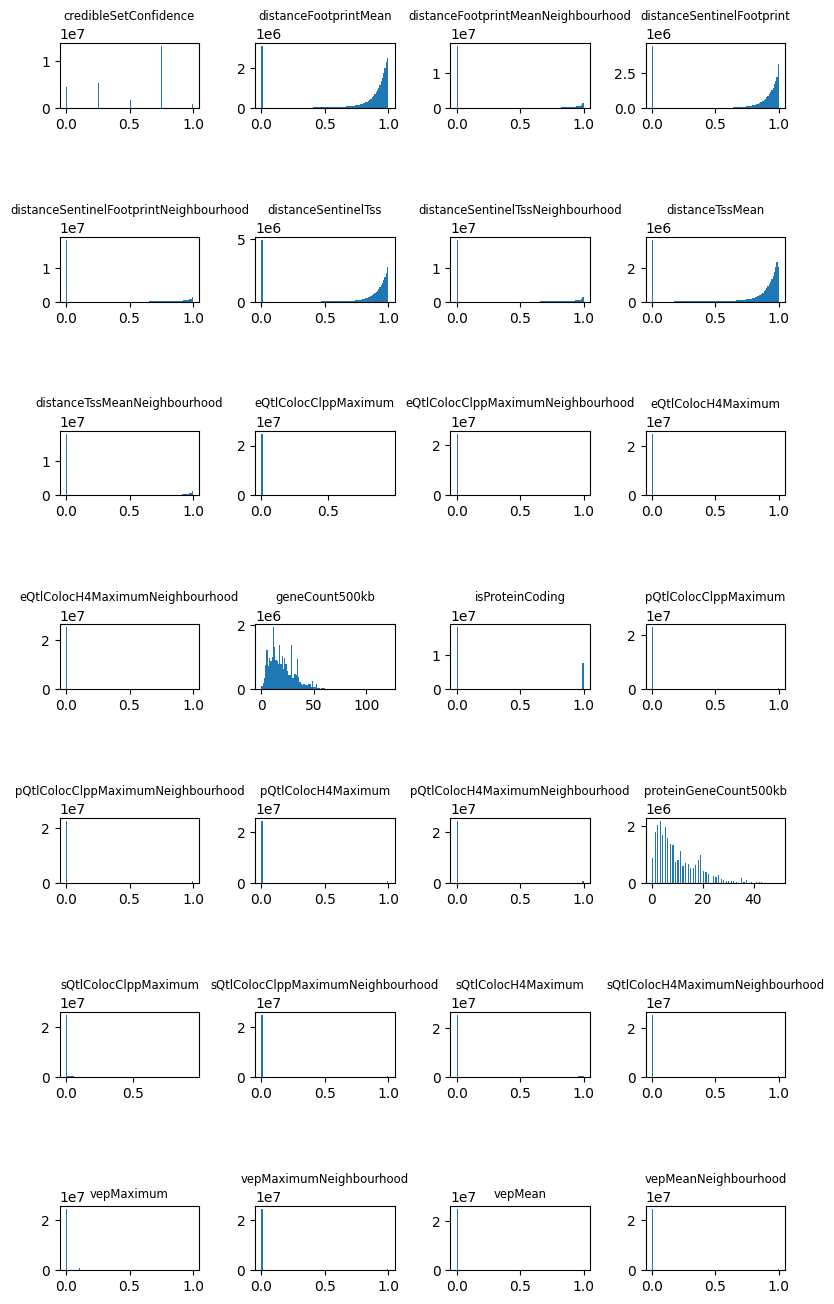

In [12]:
fm_pl = pl.read_parquet(f"{RELEASE_PATH}/l2g_feature_matrix/*.parquet")
fig = plot_distributions(fm_pl, feature_cols=features)
plt.show()

Since the features are skewed torwards right side, lets calculate the skewness

In [13]:
with pl.Config(tbl_rows=len(features)):
    skew_df = calculate_skewness(fm_pl, feature_cols=features)
    print(skew_df)

shape: (28, 2)
┌─────────────────────────────────┬───────────┐
│ feature_name                    ┆ value     │
│ ---                             ┆ ---       │
│ str                             ┆ f64       │
╞═════════════════════════════════╪═══════════╡
│ distanceFootprintMean           ┆ -1.903504 │
│ distanceTssMean                 ┆ -1.717013 │
│ distanceSentinelFootprint       ┆ -1.571269 │
│ distanceSentinelTss             ┆ -1.43913  │
│ credibleSetConfidence           ┆ -0.500911 │
│ isProteinCoding                 ┆ 0.910598  │
│ distanceFootprintMeanNeighbour… ┆ 0.958182  │
│ distanceSentinelFootprintNeigh… ┆ 1.021568  │
│ distanceTssMeanNeighbourhood    ┆ 1.022901  │
│ distanceSentinelTssNeighbourho… ┆ 1.081101  │
│ geneCount500kb                  ┆ 1.087984  │
│ proteinGeneCount500kb           ┆ 1.250589  │
│ pQtlColocClppMaximumNeighbourh… ┆ 3.258244  │
│ pQtlColocClppMaximum            ┆ 4.651273  │
│ pQtlColocH4MaximumNeighbourhoo… ┆ 4.748006  │
│ pQtlColocH4Maximum     

The skewness is quiet diverse, this is due to the fact that we fill missing values with 0. **From what I understand how the features are build** the fill_na should only happen on coloc features. Further investigation is needed for all other features including 
- distance
- vep
for which I was not expecting so much skewness.




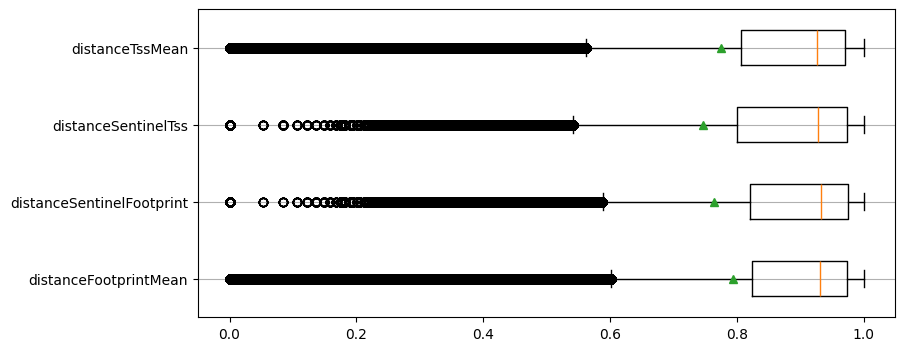

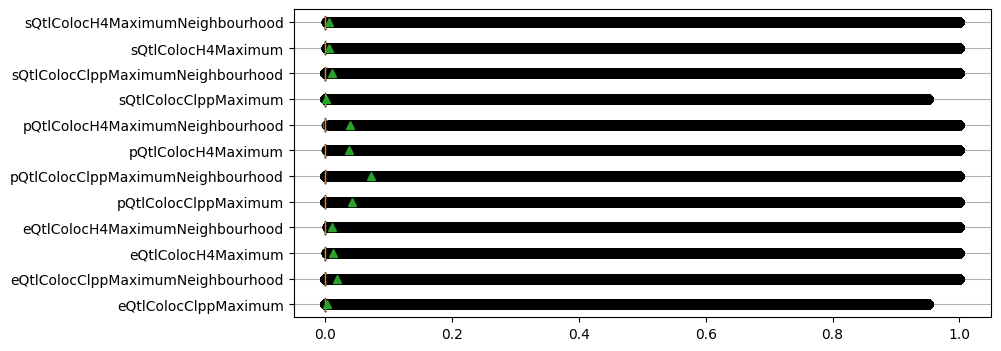

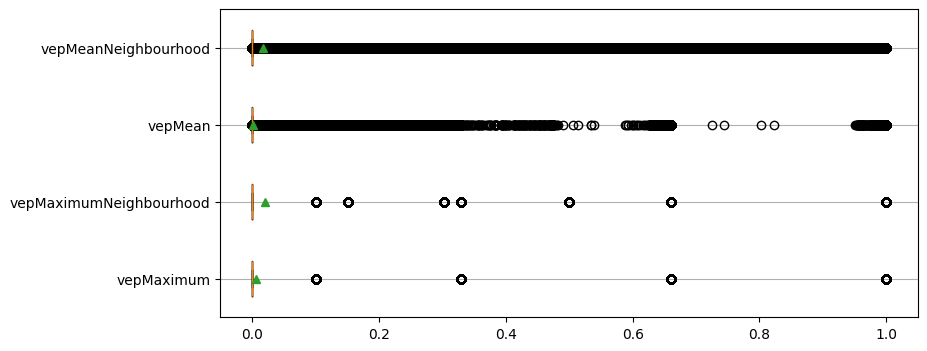

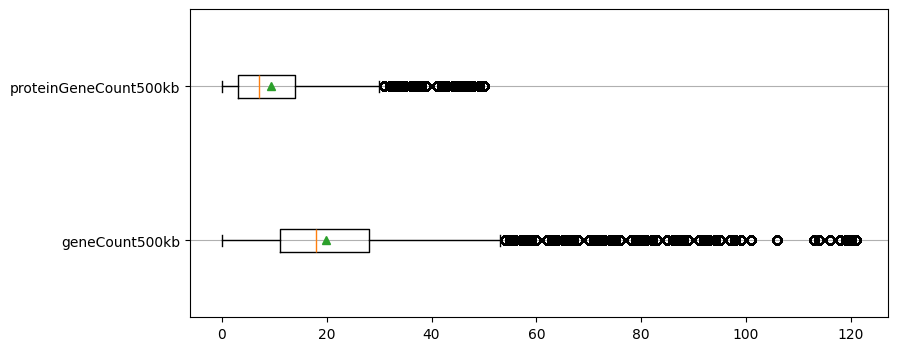

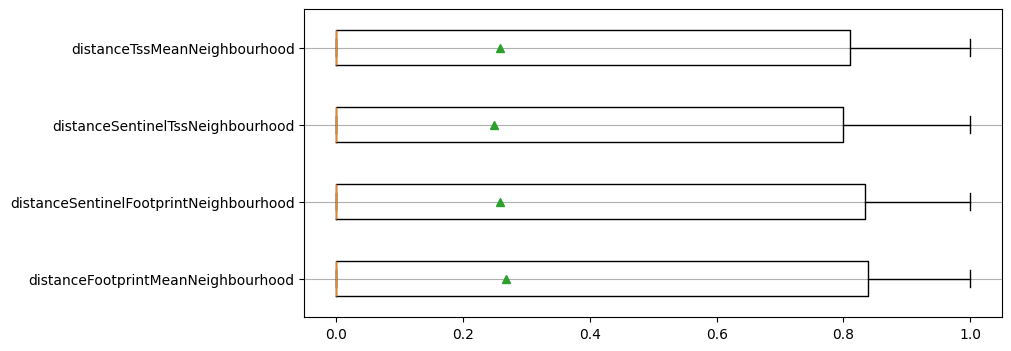

In [ ]:
distance_neighbourhood_features = [
    f for f in features if "distance" in f and f.endswith("hood")
]
distance_features = [f for f in features if "distance" in f and not f.endswith("hood")]
coloc_features = [f for f in features if "Coloc" in f]
vep_features = [f for f in features if "vep" in f]
gene_cnt_features = [f for f in features if "500kb" in f]

fig = plot_wiskers(fm_pl, distance_features)
fig2 = plot_wiskers(fm_pl, coloc_features)
fig3 = plot_wiskers(fm_pl, vep_features)
fig4 = plot_wiskers(fm_pl, gene_cnt_features)
fig5 = plot_wiskers(fm_pl, distance_neighbourhood_features)
plt.show()

Given we how have a full overview of the skewed data, I would like to try using the `power_transform`. lets have a look at the example with the colocalisation featues.

#### Disclaimer

Since we use an ensembl algorithm that is based on tree, the transformation of the features may have minimal to none impact

### Testing L2G Feature Matrix step
I need to make the L2GFeatureMatrix as a dataset. The `Dataset` in gentropy requires a default schema type to be used to validate it. In the case of L2GFeatureMatrix we know for sure that there will be **at least two fields** - 
- studyLocusId
- geneId
All other fields represent features, so they are dynamically generated.

To solve the schema check I want to do the folllowing:

1. LocusToGeneFeatureMatrix step build the feature matrix with all possible features and dumps it as a parquet file
2. Any other step can use the `L2GFeatureMatrix` dataset that has the fixed columns represented in the `static schema`. The `__init__` function for the `L2GFeatureMatrix` should contain the `feature_list` that represents which fields should be read from the dataset including `static schema`. This way we do not need to filter the full dataset 
3. By default `feature_list` should represent all features
4. schema is dynamically build for the `L2GFeatureMatrix.from_parquet()` which requires the `Dataset.from_parquet()` and allow the `feature_list` flag to limit the dataset to specific fields.

In [14]:
from gentropy.dataset.l2g_feature_matrix import L2GFeatureMatrix
from gentropy.dataset.l2g_features.namespace import L2GFeatureName

Now I want to load the L2GFeatureMatrix with default loader to see what is changed

In [16]:
all_features = list(map(str, L2GFeatureName))
l2g_fm = L2GFeatureMatrix(fm, features_list=all_features)

In [ ]:
full_schema = l2g_fm._df.schema.jsonValue()

In [25]:
import json

with open("../src/gentropy/assets/schemas/l2g_feature_matrix.json", "w") as f:
    json.dump(full_schema, f, indent=2)

Only change to the original schema after using the default iterator is the fact that it aligns all values to `floatType` 

In [26]:
full_schema

{'type': 'struct',
 'fields': [{'name': 'studyLocusId',
   'type': 'string',
   'nullable': True,
   'metadata': {}},
  {'name': 'geneId', 'type': 'string', 'nullable': True, 'metadata': {}},
  {'name': 'eQtlColocClppMaximum',
   'type': 'float',
   'nullable': True,
   'metadata': {}},
  {'name': 'eQtlColocClppMaximumNeighbourhood',
   'type': 'float',
   'nullable': True,
   'metadata': {}},
  {'name': 'pQtlColocClppMaximum',
   'type': 'float',
   'nullable': True,
   'metadata': {}},
  {'name': 'pQtlColocClppMaximumNeighbourhood',
   'type': 'float',
   'nullable': True,
   'metadata': {}},
  {'name': 'sQtlColocClppMaximum',
   'type': 'float',
   'nullable': True,
   'metadata': {}},
  {'name': 'sQtlColocClppMaximumNeighbourhood',
   'type': 'float',
   'nullable': True,
   'metadata': {}},
  {'name': 'eQtlColocH4Maximum',
   'type': 'float',
   'nullable': True,
   'metadata': {}},
  {'name': 'eQtlColocH4MaximumNeighbourhood',
   'type': 'float',
   'nullable': True,
   'metadata

In [34]:
from gentropy.common.schemas import parse_spark_schema

In [36]:
ss = parse_spark_schema("l2g_feature_matrix.json")

In [40]:
from pyspark.sql import types as t

In [54]:
remove_fields_from_schema(ss, fields_name=["geneId"])

StructType([StructField('studyLocusId', StringType(), True)])

In [50]:
ss.fields = [f for f in ss.fields if f.name != "gene_id"]

In [52]:
ss.fields

[StructField('studyLocusId', StringType(), True),
 StructField('geneId', StringType(), True)]

In [39]:
ss.drop

[StructField('studyLocusId', StringType(), True),
 StructField('geneId', StringType(), True)]

In [55]:
from gentropy.dataset.variant_index import VariantIndex

In [56]:
vi = VariantIndex.from_parquet(session, f"{RELEASE_PATH}/variant")

In [64]:
distances.show()

+--------------------+---------------+---------------+
|           variantId|       targetId|distanceFromTss|
+--------------------+---------------+---------------+
|10_104048097_AGCA...|ENSG00000283788|             89|
|    10_104067557_A_G|ENSG00000297750|             10|
|  10_104121104_GGC_G|ENSG00000294047|             97|
|    10_104218932_A_T|ENSG00000208033|             49|
|    10_104245971_G_T|ENSG00000302085|             48|
|    10_104245977_T_C|ENSG00000302085|             54|
|    10_104246019_C_T|ENSG00000302085|             96|
|   10_104248980_T_TA|ENSG00000302072|             90|
|    10_104249033_C_T|ENSG00000302072|             37|
|    10_104254967_G_A|ENSG00000148834|             75|
|    10_104268312_T_C|ENSG00000266852|             93|
|    10_104268396_G_A|ENSG00000266852|              9|
|    10_104268399_G_T|ENSG00000266852|              6|
|    10_104268492_C_T|ENSG00000266852|             87|
|    10_104268971_C_G|ENSG00000302058|             19|
|    10_10

In [86]:
distances = vi.get_distance_to_gene(max_distance=99, distance_type="distanceFromTss")
target_index = session.spark.read.parquet(f"{RELEASE_PATH}/target")

In [106]:
from pyspark.sql import functions as f
from gentropy.common.utils import extract_position

distances.alias("distance").join(
    target_index.alias("target"),
    on=distances["targetId"] == target_index["id"],
).select(
    "id",
    "approvedSymbol",
    "canonicalTranscript",
    "genomicLocation",
    "tss",
    "distanceFromTss",
    extract_position("variantId").alias("variant_position"),
).show(truncate=False, vertical=True)

-RECORD 0-------------------------------------------------------------
 id                  | ENSG00000283788                                
 approvedSymbol      | MIR936                                         
 canonicalTranscript | {ENST00000401264, 10, 104048089, 104048186, -} 
 genomicLocation     | {10, 104048089, 104048186, -1}                 
 tss                 | 104048186                                      
 distanceFromTss     | 89                                             
 variant_position    | 104048097                                      
-RECORD 1-------------------------------------------------------------
 id                  | ENSG00000297750                                
 approvedSymbol      | ENSG00000297750                                
 canonicalTranscript | NULL                                           
 genomicLocation     | {10, 104067547, 104119279, 1}                  
 tss                 | NULL                                           
 dista

In [108]:
distances.filter(f.col("targetId") == "ENSG00000283788").show()

+--------------------+---------------+---------------+
|           variantId|       targetId|distanceFromTss|
+--------------------+---------------+---------------+
|10_104048097_AGCA...|ENSG00000283788|             89|
+--------------------+---------------+---------------+



In [117]:
target_index.filter(f.size("transcriptIds") > 0).select(
    "tss", "genomicLocation", "id", "canonicalTranscript"
).show(truncate=False)

+---------+-----------------------------+---------------+---------------------------------------------+
|tss      |genomicLocation              |id             |canonicalTranscript                          |
+---------+-----------------------------+---------------+---------------------------------------------+
|2691295  |{X, 2691187, 2741309, 1}     |ENSG00000002586|{ENST00000381192, X, 2691295, 2741309, +}    |
|139293740|{5, 139293674, 139331677, 1} |ENSG00000015479|{ENST00000394805, 5, 139293740, 139331677, +}|
|180649600|{5, 180601506, 180649624, -1}|ENSG00000037280|{ENST00000261937, 5, 180601506, 180649600, -}|
|83471744 |{5, 83471618, 83582303, 1}   |ENSG00000038427|{ENST00000265077, 5, 83471744, 83582302, +}  |
|121164321|{4, 121131408, 121227466, -1}|ENSG00000050730|{ENST00000057513, 4, 121131408, 121164321, -}|
|43575527 |{19, 43543311, 43580473, -1} |ENSG00000073050|{ENST00000262887, 19, 43543311, 43575527, -} |
|21669357 |{1, 21596221, 21669357, -1}  |ENSG00000076864|{ENST00

In [118]:
target_index.printSchema()

root
 |-- id: string (nullable = true)
 |-- approvedSymbol: string (nullable = true)
 |-- biotype: string (nullable = true)
 |-- transcriptIds: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- canonicalTranscript: struct (nullable = true)
 |    |-- id: string (nullable = true)
 |    |-- chromosome: string (nullable = true)
 |    |-- start: long (nullable = true)
 |    |-- end: long (nullable = true)
 |    |-- strand: string (nullable = true)
 |-- canonicalExons: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- genomicLocation: struct (nullable = true)
 |    |-- chromosome: string (nullable = true)
 |    |-- start: long (nullable = true)
 |    |-- end: long (nullable = true)
 |    |-- strand: integer (nullable = true)
 |-- alternativeGenes: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- approvedName: string (nullable = true)
 |-- go: array (nullable = true)
 |    |-- element: struct (containsNull = tru

In [80]:
104254967 - 104254892

75

In [1]:
from gentropy.dataset.l2g_features.distance import DistanceTssMeanNeighbourhoodFeature

Loading BokehJS ...

In [ ]:
DistanceTssMeanNeighbourhoodFeature()